In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from subprocess import check_output

np.random.seed(2020)

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
train_df = reduce_mem_usage(pd.read_csv("train.csv"))
test_df = reduce_mem_usage(pd.read_csv("test.csv"))
songs_df = reduce_mem_usage(pd.read_csv("songs.csv"))
members_df = reduce_mem_usage(pd.read_csv("members.csv"))

Memory usage of dataframe is 337.71 MB
Memory usage after optimization is: 82.41 MB
Decreased by 75.6%
Memory usage of dataframe is 117.04 MB
Memory usage after optimization is: 42.17 MB
Decreased by 64.0%
Memory usage of dataframe is 122.64 MB
Memory usage after optimization is: 159.83 MB
Decreased by -30.3%
Memory usage of dataframe is 1.84 MB
Memory usage after optimization is: 1.83 MB
Decreased by 0.5%


In [4]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [5]:
train_df.isnull().sum()

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [6]:
test_df.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [7]:
songs_df.isnull().sum()

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071358
lyricist       1945306
language             1
dtype: int64

In [8]:
songs_df.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [9]:
songs_df.genre_ids.value_counts()

genre_ids
465             567911
958             176349
2022            168870
1609            166457
2122            139938
                 ...  
829|1103             1
465|109|958          1
465|1011|691         1
829|1259             1
139|109|94           1
Name: count, Length: 1045, dtype: int64

In [10]:
df_idx = songs_df["genre_ids"].str.split('|')

In [11]:
import time

start = time.time()

songs_df = pd.concat([songs_df.drop('genre_ids', axis = 1 ), df_idx.apply(pd.Series)], axis=1)

end = time.time()
print(end - start)

975.7422921657562


In [13]:
songs_df.loc[songs_df['language'].isnull(),'language'] = 31.0

In [14]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [15]:
members_df['registration_init_time'] = pd.to_datetime(members_df['registration_init_time'], format='%Y%m%d')
members_df['reg_year'] = members_df['registration_init_time'].dt.year
members_df['reg_month'] = members_df['registration_init_time'].dt.month
members_df['reg_day'] = members_df['registration_init_time'].dt.day

members_df['expiration_date'] = pd.to_datetime(members_df['expiration_date'],  format='%Y%m%d')
members_df['exp_year'] = members_df['expiration_date'].dt.year
members_df['exp_month'] = members_df['expiration_date'].dt.month
members_df['exp_day'] = members_df['expiration_date'].dt.day

In [16]:
members_df.drop(['registration_init_time','expiration_date'] , axis = 1 , inplace= True)

In [17]:
members_df.head()

,msno,city,bd,gender,registered_via,reg_year,reg_month,reg_day,exp_year,exp_month,exp_day
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011,8,20,2017,9,20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015,6,28,2017,6,22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016,4,11,2017,7,12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015,9,6,2015,9,7
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017,1,26,2017,6,13


In [18]:
members_df['bd'] = members_df['bd'].apply(lambda x : 0 if x > 100 else abs(x) )

In [19]:
members_df['gender'] = members_df['gender'].astype("category").cat.codes

In [20]:
train_age = members_df[members_df['bd'] != 0].copy() 
y_train_age  = train_age['bd']
train_age.drop(['msno' ,'bd','gender'],axis = 1 , inplace = True )
test_age =  members_df[members_df['bd'] == 0].copy() 
y_test_age  = test_age['bd']
test_age.drop(['msno' ,'bd','gender'],axis = 1 , inplace = True )

In [21]:
train_age.head()

,city,registered_via,reg_year,reg_month,reg_day,exp_year,exp_month,exp_day
5,13,9,2012,7,3,2017,10,6
10,12,9,2006,5,31,2017,8,16
13,15,3,2015,9,15,2017,10,19
15,13,3,2014,4,10,2017,4,27
16,13,9,2007,3,30,2017,6,12


In [22]:
from lightgbm import LGBMClassifier , LGBMRegressor
from catboost import CatBoostClassifier ,CatBoostRegressor

from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [23]:
model = CatBoostRegressor(verbose = 0)
model.fit(train_age.values, y_train_age.values.ravel())
cv_score = np.sqrt(- cross_val_score(model, train_age.values,y_train_age.values.ravel(), cv=3 ,scoring='neg_mean_squared_error').mean())
cv_score

8.873272710866614

In [24]:
preds_age = model.predict(test_age.values)
preds_age = preds_age.round()
preds_age

array([38., 25., 24., ..., 28., 28., 27.])

In [25]:
members_df['bd'].value_counts()

bd
0     19954
22      751
27      750
24      740
26      719
      ...  
90        1
2         1
70        1
3         1
10        1
Name: count, Length: 80, dtype: int64

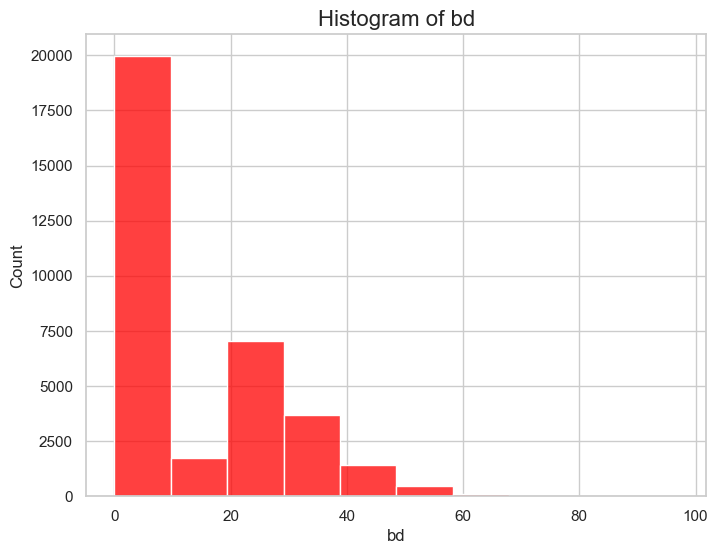

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(x='bd', data=members_df, bins=10, color='red', ax=ax)
ax.set_title('Histogram of bd', fontsize=16)

plt.show()

In [27]:
train_gender =  members_df[members_df['gender'] != 0].copy() 
y_train_gender  = train_gender['gender']
train_gender.drop(['msno','gender'],axis = 1 , inplace = True )
test_gender =  members_df[members_df['gender'] == 0].copy() 
y_test_gender  = test_gender['gender']
test_gender.drop(['msno' ,'gender'],axis = 1 , inplace = True )

In [28]:
model = CatBoostClassifier(verbose = 0 )
model.fit(train_gender.values, y_train_gender.values.ravel())
cv_score = cross_val_score(model, train_gender.values,y_train_gender.values.ravel(), cv=3 ,scoring='accuracy').mean()
cv_score

0.9811037261261389

In [29]:
predictions = model.predict(test_gender.values)

In [30]:
members_df['gender'].value_counts()

gender
-1    19902
 1     7405
 0     7096
Name: count, dtype: int64

In [31]:
gender_nulls_indexes = members_df[members_df['gender'] == 0].index
j = 0
for i in gender_nulls_indexes : 
    members_df.loc[i , 'gender'] = predictions[j]
    j += 1

In [32]:
members_df['gender'].value_counts()

gender
-1    20103
 1    14300
Name: count, dtype: int64

In [33]:
members_df.head()

,msno,city,bd,gender,registered_via,reg_year,reg_month,reg_day,exp_year,exp_month,exp_day
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,-1,7,2011,8,20,2017,9,20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,-1,7,2015,6,28,2017,6,22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,-1,4,2016,4,11,2017,7,12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,-1,9,2015,9,6,2015,9,7
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,-1,4,2017,1,26,2017,6,13


In [34]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df['target'].values
test_IDs = test_df['msno'].copy()
all_data = pd.concat((train_df.drop('target',axis =1), test_df)).reset_index(drop=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (9934208, 6)


In [35]:
all_data.drop('id', axis =1 , inplace = True)
all_data = all_data.merge(members_df, on='msno', how='left')
all_data = all_data.merge(songs_df, on = 'song_id', how = 'left')

In [36]:
del [[members_df,songs_df]]
import gc
gc.collect()

316

In [37]:
for i in range(0,8):
    all_data[i] = all_data[i].fillna(0)

In [38]:
all_data[0].value_counts()

0
465     5062629
458     1651779
921      610930
1609     450948
444      378968
         ...   
87            1
2015          1
1579          1
751           1
303           1
Name: count, Length: 165, dtype: int64

In [39]:
for i in range(0,8):
    all_data[i] = all_data[i].astype('category').cat.codes

In [40]:
all_data[0].value_counts()

0
118    5062629
117    1651779
154     610930
46      450948
115     378968
        ...   
148          1
64           1
43           1
137          1
101          1
Name: count, Length: 165, dtype: int64

In [41]:
nulls_cols = all_data.isnull().sum()
nulls_cols = nulls_cols[nulls_cols != 0]
list(nulls_cols.keys())

['source_system_tab',
 'source_screen_name',
 'source_type',
 'song_length',
 'artist_name',
 'composer',
 'lyricist',
 'language']

In [42]:
for col in list(nulls_cols.keys()): 
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [43]:
all_data.isnull().sum()

msno                  0
song_id               0
source_system_tab     0
source_screen_name    0
source_type           0
city                  0
bd                    0
gender                0
registered_via        0
reg_year              0
reg_month             0
reg_day               0
exp_year              0
exp_month             0
exp_day               0
song_length           0
artist_name           0
composer              0
lyricist              0
language              0
0                     0
1                     0
2                     0
3                     0
4                     0
5                     0
6                     0
7                     0
dtype: int64

In [44]:
all_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,reg_year,...,lyricist,language,0,1,2,3,4,5,6,7
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,0,-1,7,2012,...,阿信,52.0,105,0,0,0,0,0,0,0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,13,24,1,9,2011,...,阿信,52.0,34,0,0,0,0,0,0,0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,13,24,1,9,2011,...,阿信,52.0,34,0,0,0,0,0,0,0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,13,24,1,9,2011,...,阿信,-1.0,4,0,0,0,0,0,0,0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,0,-1,7,2012,...,阿信,52.0,3,0,0,0,0,0,0,0


In [45]:
all_data[['composer']].nunique()

composer    86438
dtype: int64

In [46]:
categorical_col = ['city','gender','registered_via','language','artist_name','composer','lyricist']
for col in all_data.columns:
    if all_data[col].dtype in [bool ,object, 'category'] and len(all_data[col].unique()) <= 50:
        categorical_col.append(col)

In [47]:
categorical_col

['city',
 'gender',
 'registered_via',
 'language',
 'artist_name',
 'composer',
 'lyricist',
 'source_system_tab',
 'source_screen_name',
 'source_type']

In [48]:
for col in categorical_col:
    # Ensure the column is not of float16 type
    if all_data[col].dtype == 'float16':
        all_data[col] = all_data[col].astype('float32')  # or 'float64'

    all_data[col] = all_data[col].astype('category').cat.codes

In [49]:
all_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,reg_year,...,lyricist,language,0,1,2,3,4,5,6,7
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1,7,6,0,0,0,2,2012,...,107558,8,105,0,0,0,0,0,0,0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,3,8,4,11,24,1,3,2011,...,107558,8,34,0,0,0,0,0,0,0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,3,8,4,11,24,1,3,2011,...,107558,8,34,0,0,0,0,0,0,0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,3,8,4,11,24,1,3,2011,...,107558,0,4,0,0,0,0,0,0,0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,1,7,6,0,0,0,2,2012,...,107558,8,3,0,0,0,0,0,0,0


In [50]:
all_data['msno'].value_counts()

msno
MXIMDXO0j3UpaT7FvOSGW6Y5zfhlh+xYjTqGoUdMzEE=    7894
o+5RNlSWrzvrphgBNGIo1FLkGxBgyICns6qXj3nS7Pk=    7318
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=    7075
KGXNZ/H3VxvET/+rGxlrAe7Gpz2eKMXyuSg3xh8Ij1M=    6706
cqjRBV/jWN2ujhc+z/4tz+Mj6xEfflAAt6qBXCqxKvw=    5446
                                                ... 
U8+k0YmjY2aDIM7Wd9ejIF/XqZkoWbBlv+2booso86A=       1
0Yby35OBCWJyG0HOTIx003npPQ8mMY51ZI+Q6JulBqI=       1
YBw/FWdyTgpVStJFzPn0aVf3/dtQwxAiHmvAu3pxyoI=       1
g0cf2zdSgmLeBAHJZJZc85VD4l6f6xKkNegrh8VEAms=       1
q9mrx9lx8969hkkTf4h96PqKeeG0DTC5iMLuc/6VDSI=       1
Name: count, Length: 34403, dtype: int64

In [51]:
print('in',all_data.columns.map(type))
all_data.columns = all_data.columns.astype(str)
print('out',all_data.columns.map(type))

in Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>,
       <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>],
      dtype='object')
out Index([<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>,
       <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>],
      dtype='object')


In [52]:
train_data = all_data[:ntrain].copy()
test_data = all_data[ntrain:]
train_data['target'] = y_train

train_data.shape , test_data.shape

((7377418, 29), (2556790, 28))

In [53]:
train_data['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int8

In [54]:
print(train_data['target'].dtype)

train_data['target'] = train_data['target'].astype(int)
train_data['target'] = train_data['target'].astype("category").cat.codes

int8


In [55]:
train_data['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int8

In [56]:
X_train = train_data.drop(['target','msno','song_id'], axis = 1)
test_data = test_data.drop(['msno','song_id'],axis = 1)
y_train = train_data.target
X_train.shape , y_train.shape

((7377418, 26), (7377418,))

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PowerTransformer
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
test_data_scaled = scaler.transform(test_data)

In [58]:
X_train = X_train_scaled
test_data = test_data_scaled

In [60]:
import lightgbm as lgb
import time

start = time.time()

train_set = lgb.Dataset(X_train, y_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'learning_rate': 0.3,
    'num_leaves': 216,
    'bagging_fraction': 0.95,
    'bagging_freq': 1,
    'bagging_seed': 1,
    'feature_fraction': 0.9,
    'feature_fraction_seed': 1,
    'max_bin': 510,
    'max_depth': 20,
    'num_rounds': 500,
    'metric': 'auc',
    'verbose': 5,
}

%time model_f1 = lgb.train(params, train_set=train_set)

end = time.time()
print(end - start)


[LightGBM] [Info] Number of positive: 3714656, number of negative: 3662762
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.977307
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.300710
[LightGBM] [Debug] init for col-wise cost 0.337821 seconds, init for row-wise cost 2.185139 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.650078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 7377418, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503517 -> initscore=0.014069
[LightGBM] [Info] Start training from score 0.014069
[LightGBM] [Debug] Re-bagging, using 7009189 data to train
[LightGBM] [Debug] Trained a tree with leaves = 216 and depth = 20
[LightGBM

In [61]:
predictions = model_f1.predict(pd.DataFrame(test_data).values)
sub = pd.DataFrame()
sub['id'] = test_df['id']
sub['target'] = predictions
sub.to_csv('submission.csv',index=False)
sub.head()

,id,target
0,0,0.504507
1,1,0.605063
2,2,0.117979
3,3,0.151027
4,4,0.068970
